In [8]:
import easyocr as eo
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2


In [2]:
img_path = 'billa/billa_1.jpeg'

In [3]:
from PIL import Image, ExifTags
import numpy as np

def get_oriented_image_array(image_path):
    """
    Loads an image, checks its EXIF orientation metadata, and applies the correct rotation.
    Returns a NumPy array suitable for OCR or OpenCV processing.
    """
    image = Image.open(image_path)

    try:
        for orientation in ExifTags.TAGS:
            if ExifTags.TAGS[orientation] == 'Orientation':
                break

        exif = image._getexif()
        if exif is not None:
            orientation_value = exif.get(orientation, None)

            if orientation_value == 3:
                image = image.rotate(180, expand=True)
            elif orientation_value == 6:
                image = image.rotate(270, expand=True)
            elif orientation_value == 8:
                image = image.rotate(90, expand=True)
    except Exception as e:
        print("❗ Orientation adjustment skipped:", e)

    return np.array(image)


In [4]:
image_np = get_oriented_image_array('billa/billa_1.jpeg')

# Run OCR directly on the image array
reader = eo.Reader(['en', 'bg'])
results = reader.readtext(image_np)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
c:\Users\Iliyan Tashinov\Desktop\open-shelf\venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [10]:
def display_results(results, image_np, result_path):
    """
    Displays and saves OCR results drawn on an image.
    
    Parameters:
        results     — EasyOCR results (list of (bbox, text, confidence))
        image_np    — Image as NumPy array (e.g., from get_oriented_image_array)
        result_path — Filename (without extension) to save output under 'results/'
    """
    image = image_np.copy()

    for bbox, text, confidence in results:
        pts = [tuple(map(int, point)) for point in bbox]
        cv2.polylines(image, [np.array(pts)], isClosed=True, color=(0, 255, 0), thickness=4)
        cv2.putText(image, text, pts[0], cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    # Convert BGR to RGB for display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Show using matplotlib
    plt.figure(figsize=(12, 12))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title("OCR Results")
    plt.show()

    # Save the image with drawn boxes
    cv2.imwrite(f'results/{result_path}.jpg', image)


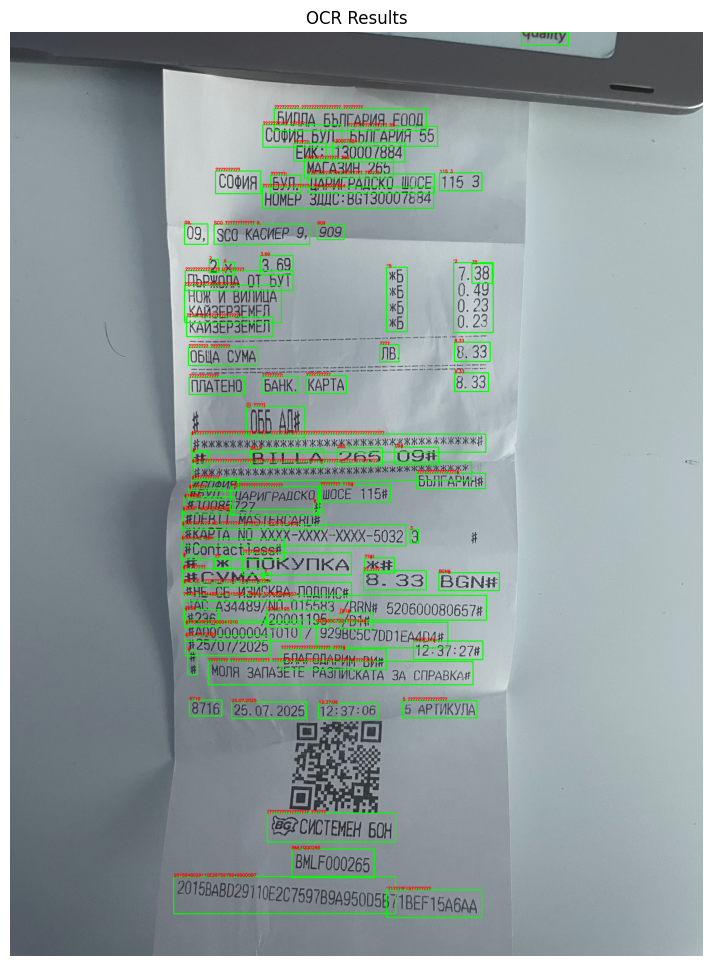

In [11]:
display_results(results,image_np,'billa_1')

In [12]:
print(results)

[([[np.int32(2231), 0], [np.int32(2436), 0], [np.int32(2436), np.int32(58)], [np.int32(2231), np.int32(58)]], 'qчашпу', np.float64(0.5588771359151764)), ([[np.int32(1153), np.int32(333)], [np.int32(1816), np.int32(333)], [np.int32(1816), np.int32(430)], [np.int32(1153), np.int32(430)]], 'БИЛЛА БЬЛГАРИЯ ЕООД', np.float64(0.7901511115055069)), ([[np.int32(1103), np.int32(404)], [np.int32(1447), np.int32(404)], [np.int32(1447), np.int32(502)], [np.int32(1103), np.int32(502)]], 'СОФИЯ БУЛ:', np.float64(0.990001151731097)), ([[np.int32(1473), np.int32(411)], [np.int32(1865), np.int32(411)], [np.int32(1865), np.int32(498)], [np.int32(1473), np.int32(498)]], 'БЬЛГАРИЯ 55', np.float64(0.5574917577185323)), ([[np.int32(1238), np.int32(485)], [np.int32(1379), np.int32(485)], [np.int32(1379), np.int32(563)], [np.int32(1238), np.int32(563)]], 'ЕИК:', np.float64(0.9991536736488342)), ([[np.int32(1407), np.int32(481)], [np.int32(1723), np.int32(481)], [np.int32(1723), np.int32(567)], [np.int32(1407)